**Mount the Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports and Configs

In [ ]:
!pip install keras-cv keras-core -q --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 15.1 MB/s eta 0:00:00


**Imports**

In [ ]:
# Deafault Imports
import os
import logging
import functools
import warnings as wr
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_cv as kcv
from tensorflow import keras as tfk
from keras import layers as tkl
from keras import models as tkm
from keras.preprocessing.image import ImageDataGenerator, random_shear, random_shift
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

!wget https://storage.googleapis.com/storage.barbiero.dev/public_data_clean_balanced.npz

Using TensorFlow backend
--2023-11-11 22:58:31--  https://storage.googleapis.com/storage.barbiero.dev/public_data_clean_balanced.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.207, 108.177.127.207, 172.217.218.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230057449 (219M) [application/octet-stream]
Saving to: ‘public_data_clean_balanced.npz’

public_data_clean_b 100%[===================>] 219.40M   122MB/s    in 1.8s    

2023-11-11 22:58:34 (122 MB/s) - ‘public_data_clean_balanced.npz’ saved [230057449/230057449]



**Randomnes and Configurations**

In [ ]:
# Random Configuration - All
RND = True
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**Defining Functions**

In [ ]:
# Plotting Functions
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()
def plot_confusion_matrix(model, test, test_lbls, figsize, name_jpg):
  # Compute the confusion matrix
  tp = model.predict(test, verbose=0)
  cm = confusion_matrix(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1))

  # Compute classification metrics
  accuracy = accuracy_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1))
  precision = precision_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')
  recall = recall_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')
  f1 = f1_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')

  # Display the computed metrics
  print('Accuracy:\t', accuracy.round(4))
  print('Precision:\t', precision.round(4))
  print('Recall:\t\t', recall.round(4))
  print('F1:\t\t', f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=figsize, dpi=200)
  sns.heatmap(cm.T, annot=True, cmap='Blues')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.savefig(name_jpg)
  plt.show()
def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")

#plot_images(IMGS[:25], LBLS[:25], 0, 5, 5)

# Test
def test_prediction(model, test, test_lbls):
  tp = model.predict(test, verbose=0)
  tp = np.argmax(tp, axis=-1)
  tgt = np.argmax(test_lbls, axis=-1)
  test_accuracy = accuracy_score(tgt, tp)
  print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
  print()

def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

### Data Initizialization

In [ ]:
# Initializate
images, labels = np.load('public_data_clean_balanced.npz', allow_pickle=True).values()

print('Images shape: ', images.shape)
print('Labels shape: ', labels.shape)

labels_map = {0: "healthy", 1: "unhealthy"}
labels_rev_map = {"healthy": 0, "unhealthy": 1}
labels = np.array([labels_rev_map[label] for label in labels])

Images shape:  (6120, 96, 96, 3)
Labels shape:  (6120,)


In [ ]:
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images,
    labels,
    test_size = 0.15,
    **({"random_state":SEED} if not RND else {}),
    stratify = labels
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 0.15,
    **({"random_state":SEED} if not RND else {}),
    stratify = y_train_val
)

y_train = tfk.utils.to_categorical(y_train, 2)
y_val = tfk.utils.to_categorical(y_val, 2)
y_test = tfk.utils.to_categorical(y_test, 2)

# Get the Shape of IN OUT
input_shape = X_test.shape[1:]
output_shape = y_test.shape[1]                                                        # Enable for MultiClass Problem

print(f'Input shape of the Network: {input_shape}')
print(f'Output shape of the Network: {output_shape}')
print()

Input shape of the Network: (96, 96, 3)
Output shape of the Network: 2



In [ ]:
np.savez_compressed("augm_gio_split_001.npz", X_train_val, X_test, y_train_val, y_test)

In [ ]:
# create a dataset object for each set
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (96, 96)

def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    return {"images": image, "labels": label}


def prepare_trainset(dataset):
    return (
            dataset.shuffle(10 * BATCH_SIZE)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
        )

def prepare_valset(dataset):
    return dataset.map(to_dict, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)


train_dataset = prepare_trainset(train_dataset)
val_dataset = prepare_valset(val_dataset)

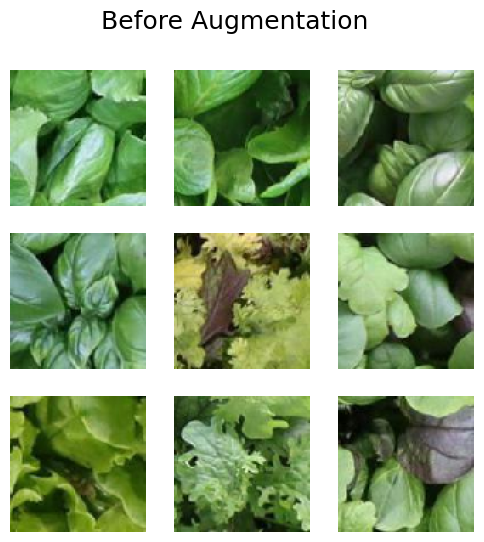

In [ ]:
visualize_dataset(train_dataset, title="Before Augmentation")

**Augmentation Layers**

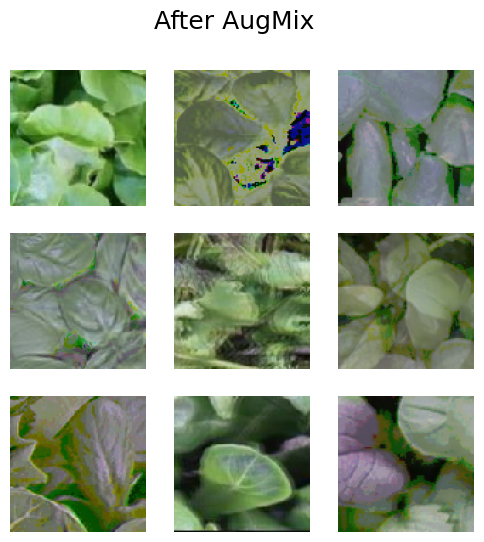

In [ ]:
aug_mix = kcv.layers.AugMix([0, 255])

def apply_aug_mix(inputs):
    inputs["images"] = aug_mix(inputs["images"])
    return inputs

res = train_dataset.map(apply_aug_mix, num_parallel_calls=AUTOTUNE)

visualize_dataset(res, title="After AugMix")

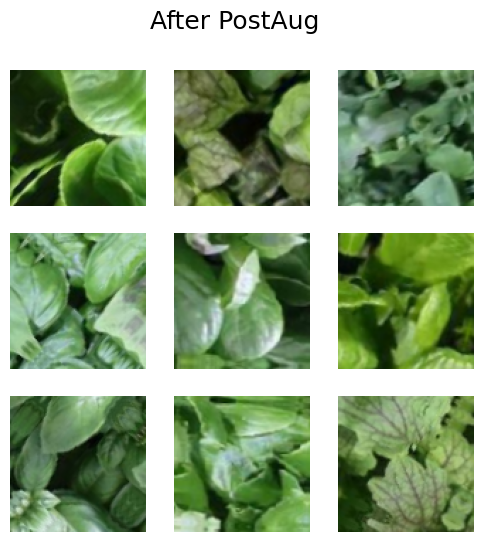

In [ ]:
post_aug = tfk.Sequential([
    tkl.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2)),
    tkl.RandomFlip(),
    tkl.RandomRotation(factor=0.5)
])

def apply_post_aug(inputs):
    inputs["images"] = post_aug(inputs["images"])
    return inputs

res = train_dataset.map(apply_post_aug, num_parallel_calls=AUTOTUNE)

visualize_dataset(res, title="After PostAug")

### Training

In [ ]:
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

train_dataset = (
    train_dataset
    .map(apply_aug_mix, num_parallel_calls=AUTOTUNE)
    #.map(apply_post_aug, num_parallel_calls=AUTOTUNE)
    .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
)

val_dataset = (
    val_dataset
    .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
)

train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

**Define the Model**

In [ ]:
from keras.applications.convnext import preprocess_input

def apple_elixir_model(input_shape, output_shape):

  # TO CHANGE - res of the Model
  res = tfk.applications.ConvNeXtBase(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    classes=2,
    classifier_activation='softmax'
  )

  res.trainable = False
  input_layer = tkl.Input(input_shape)

  x = preprocess_input(input_layer)
  x = res(x)
  x = tkl.GlobalAveragePooling2D()(x)
  x = tkl.Dense(units=128,activation=tkl.LeakyReLU(alpha=0.3))(x)                 # maybe we have to use leakyrelu
  x = tkl.Dropout(0.7)(x)

  output_layer = tkl.Dense(units=output_shape,activation='softmax')(x)
  model =tfk.Model(input_layer, output_layer)

  # Compile the model
  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001),
      metrics=['accuracy']
  )

  return model

model = apple_elixir_model(input_shape,output_shape)


350926856/350926856 [==============================] - 10s 0us/step


**Train the Model**

In [ ]:
# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                         # Metric to monitor (validation mean squared error in this case)
    patience=5,                                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.85,                                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                                     # Minimum learning rate
)

#callbacks = [early_stopping, lr_scheduler] NO NEED FOR ReduceLROnPlateau when training top
callbacks = [early_stopping]

history = model.fit(
    train_dataset,
    epochs = 300,
    validation_data = val_dataset,
    callbacks = callbacks
).history

Epoch 1/300
139/139 [==============================] - 106s 510ms/step - loss: 0.7539 - accuracy: 0.6435 - val_loss: 0.5626 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 2/300
139/139 [==============================] - 47s 337ms/step - loss: 0.6020 - accuracy: 0.6983 - val_loss: 0.5224 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 3/300
139/139 [==============================] - 48s 343ms/step - loss: 0.5500 - accuracy: 0.7256 - val_loss: 0.4897 - val_accuracy: 0.7503 - lr: 0.0010
Epoch 4/300
139/139 [==============================] - 45s 321ms/step - loss: 0.5400 - accuracy: 0.7349 - val_loss: 0.4742 - val_accuracy: 0.7657 - lr: 0.0010
Epoch 5/300
139/139 [==============================] - 45s 321ms/step - loss: 0.5273 - accuracy: 0.7406 - val_loss: 0.4111 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 6/300
139/139 [==============================] - 45s 323ms/step - loss: 0.5115 - accuracy: 0.7478 - val_loss: 0.4926 - val_accuracy: 0.7516 - lr: 0.0010
Epoch 7/300
139/139 [========================

### Saving and Plotting

In [ ]:
NAME_MODEL = "ConvNeXtCV_002"
NAME_PLOT = NAME_MODEL + "_plot"
NAME_CMATRIX = NAME_MODEL + "_cmatrix"

**Test Prediction Accuracy**

In [ ]:
test_prediction(model, X_test, y_test)

Accuracy Score over the Test Set: 0.8803



**Plots Loss**

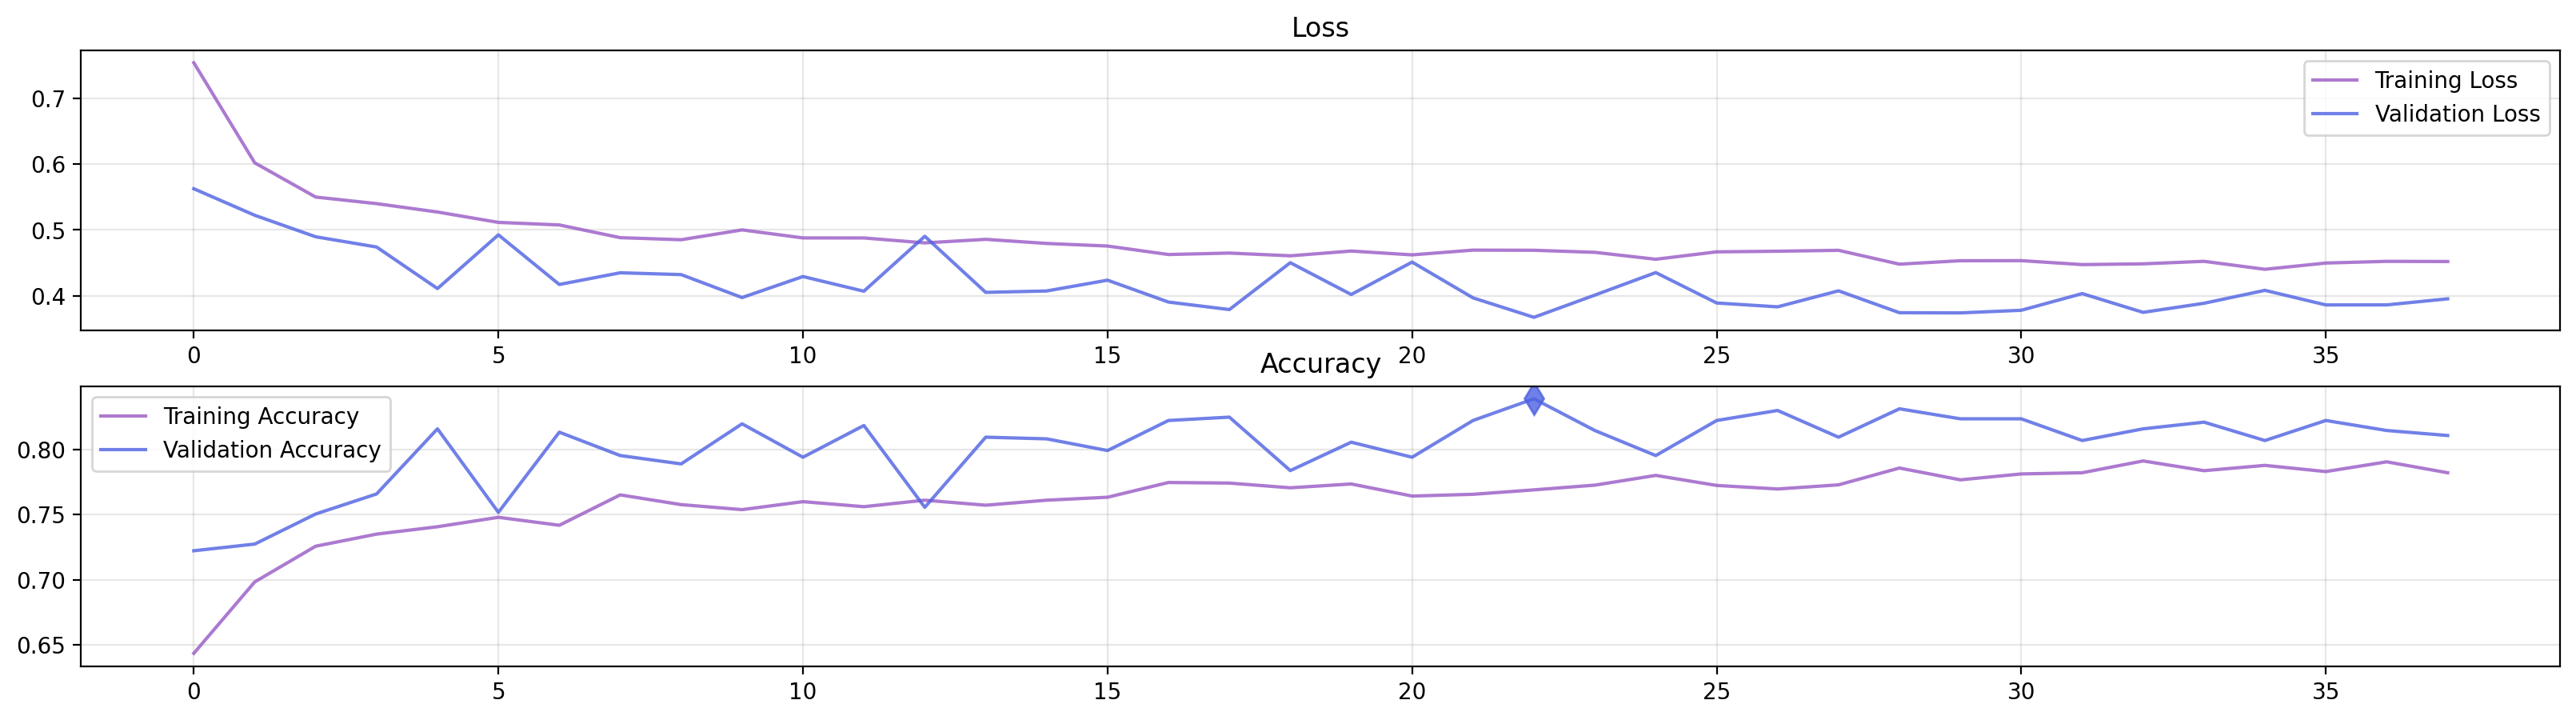

In [ ]:
plot_losses(history, (20,5), NAME_PLOT)

**Plot Confusion Matrix**

Accuracy:	 0.8377
Precision:	 0.839
Recall:		 0.8377
F1:		 0.8375


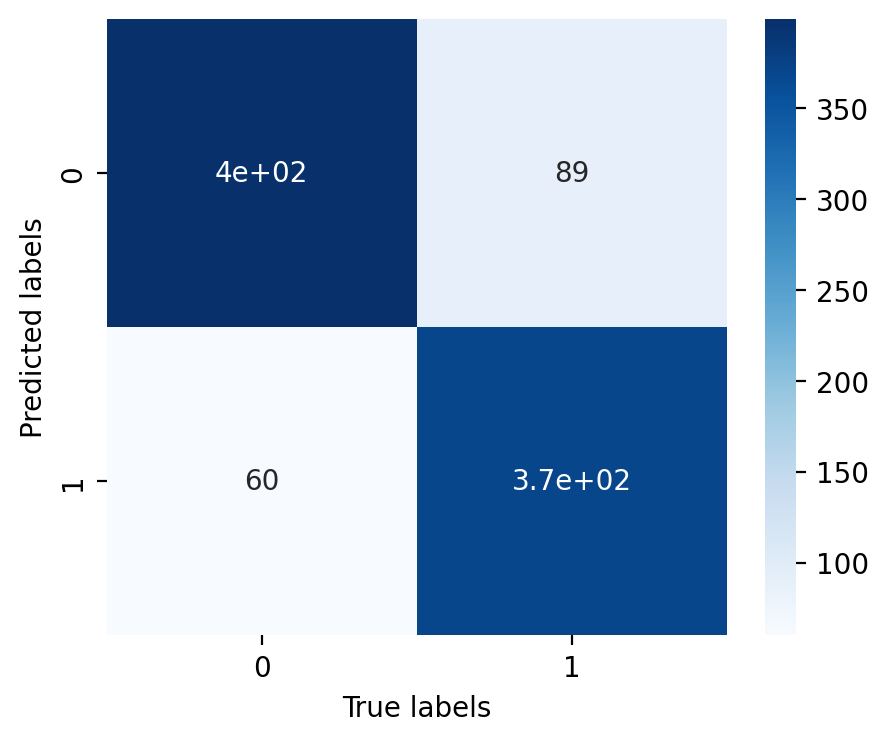

In [ ]:
plot_confusion_matrix(model, X_test, y_test, (5,4), NAME_CMATRIX)

**Save the Model**

In [ ]:
model.save(NAME_MODEL)

**Zip Model and Plots**

In [ ]:
!zip -r {NAME_MODEL}.zip {NAME_MODEL} {NAME_PLOT}.png {NAME_CMATRIX}.png

  adding: ConvNeXtCV_002/ (stored 0%)
  adding: ConvNeXtCV_002/variables/ (stored 0%)
  adding: ConvNeXtCV_002/variables/variables.index (deflated 77%)
  adding: ConvNeXtCV_002/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ConvNeXtCV_002/saved_model.pb (deflated 92%)
  adding: ConvNeXtCV_002/fingerprint.pb (stored 0%)
  adding: ConvNeXtCV_002/keras_metadata.pb (deflated 96%)
  adding: ConvNeXtCV_002/assets/ (stored 0%)
  adding: ConvNeXtCV_002_plot.png (deflated 11%)
  adding: ConvNeXtCV_002_cmatrix.png (deflated 18%)


In [ ]:
!cp {NAME_MODEL}.zip drive/MyDrive/

In [ ]:
!cp augm_gio_split_001.npz drive/MyDrive/

**Delete the Model**

In [ ]:
del model, history

## Tuning

**Load the Model**

In [ ]:
ft_model = tfk.models.load_model(NAME_MODEL)

**Count the Layers**

In [ ]:
ft_model.get_layer('convnext_base').trainable = True
c = 0
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
   c += 1

print("Layers: ",c)
print()

Layers:  295



**Train only the Last Layers**

In [ ]:
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:200]):
  layer.trainable=False

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001), metrics=['accuracy'])

**Train the Tuning Model**

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',         # Metric to monitor (validation mean squared error in this case)
    patience=5,                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.80,                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                     # Minimum learning rate
)

callbacks = [early_stopping,lr_scheduler]

history = ft_model.fit(
    train_dataset,
    epochs = 300,
    validation_data = val_dataset,
    callbacks = callbacks
).history

Epoch 1/300
139/139 [==============================] - 131s 480ms/step - loss: 0.5201 - accuracy: 0.7620 - val_loss: 0.3693 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 2/300
139/139 [==============================] - 46s 326ms/step - loss: 0.4069 - accuracy: 0.8157 - val_loss: 0.2661 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 3/300
139/139 [==============================] - 50s 354ms/step - loss: 0.3848 - accuracy: 0.8213 - val_loss: 0.3230 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 4/300
139/139 [==============================] - 48s 340ms/step - loss: 0.3467 - accuracy: 0.8485 - val_loss: 0.4810 - val_accuracy: 0.8233 - lr: 0.0010
Epoch 5/300
139/139 [==============================] - 49s 346ms/step - loss: 0.3640 - accuracy: 0.8380 - val_loss: 0.2898 - val_accuracy: 0.8835 - lr: 0.0010
Epoch 6/300
139/139 [==============================] - 51s 364ms/step - loss: 0.3254 - accuracy: 0.8555 - val_loss: 0.2277 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 7/300
139/139 [========================

### Saving and Plotting

In [ ]:
FT_NAME = NAME_MODEL+"_Tuning"
FT_PLOT = NAME_PLOT+"_Tuning"
FT_CMATRIX = NAME_CMATRIX+"_Tuning"

**Test Prediction Accuracy**

In [ ]:
test_prediction(ft_model, X_test, y_test)

Accuracy Score over the Test Set: 0.9629



**Plot Loss**

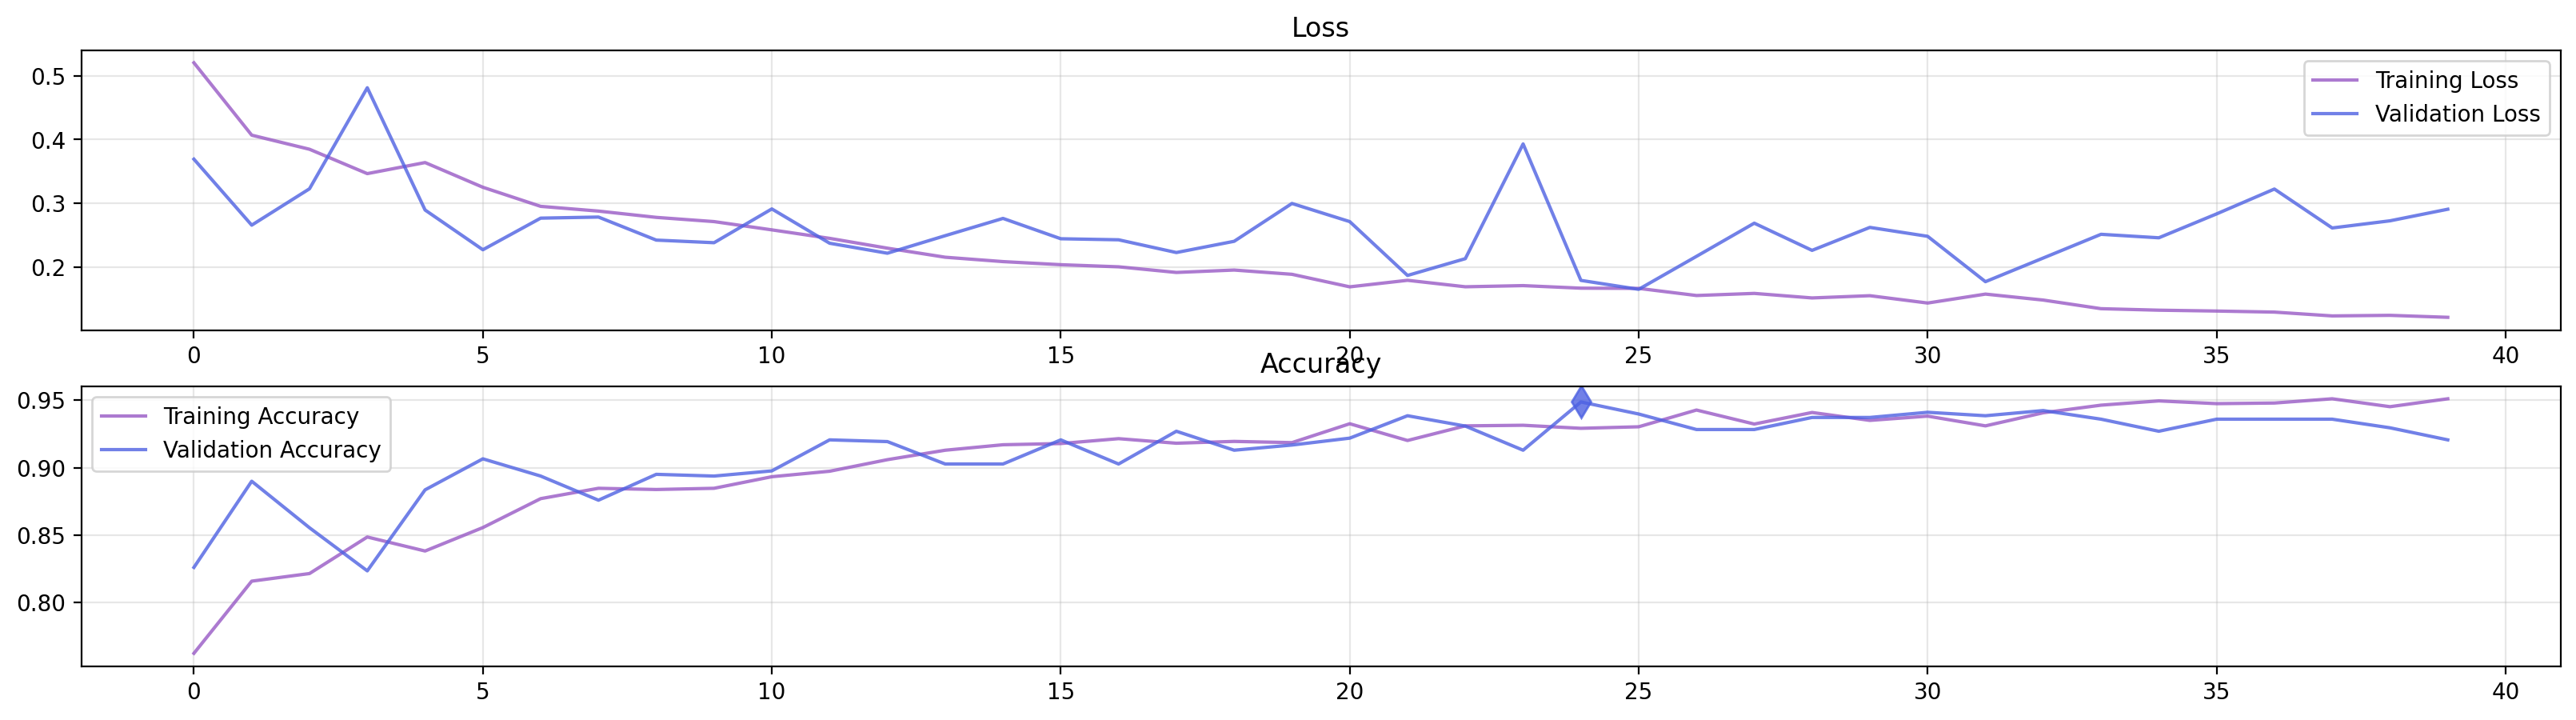

In [ ]:
plot_losses(history, (20,5), FT_NAME)

**Plot Confusion Matrix**

Accuracy:	 0.9325
Precision:	 0.9328
Recall:		 0.9325
F1:		 0.9325


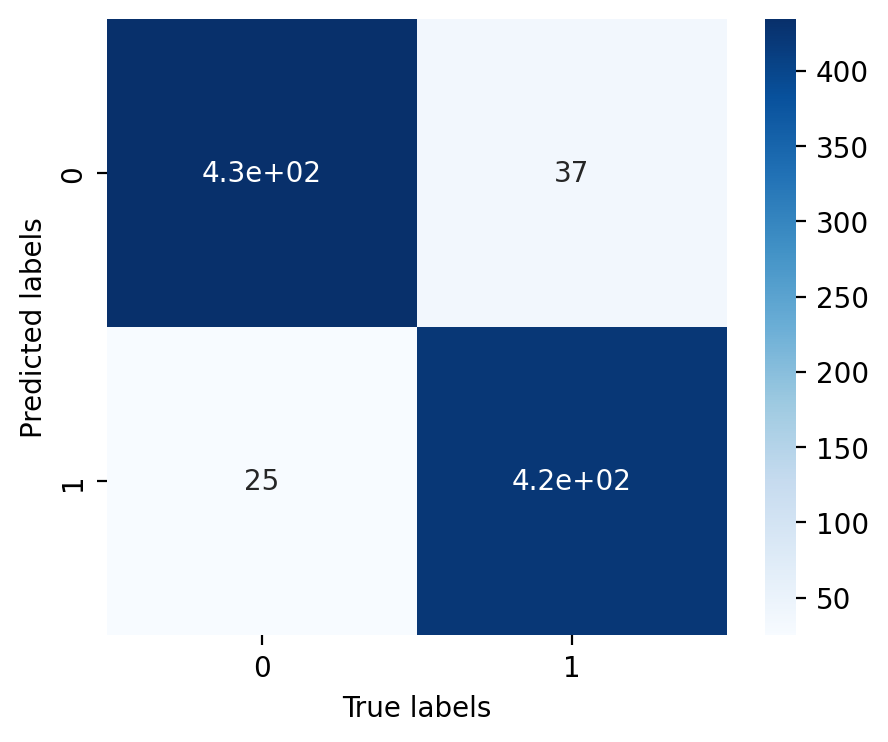

In [ ]:
plot_confusion_matrix(ft_model, X_test, y_test, (5,4), NAME_CMATRIX)

**Save the Model**

In [ ]:
ft_model.save(NAME_MODEL+"_Tuning")

**Zip the Model and the Plots**

In [ ]:
!zip -r {FT_NAME}.zip {FT_NAME} {FT_PLOT}.png {FT_CMATRIX}.png

	zip warning: name not matched: ConvNeXtV2_006_1_plot_Tuning.png
	zip warning: name not matched: ConvNeXtV2_006_1_cmatrix_Tuning.png
  adding: ConvNeXtV2_006_1_Tuning/ (stored 0%)
  adding: ConvNeXtV2_006_1_Tuning/variables/ (stored 0%)
  adding: ConvNeXtV2_006_1_Tuning/variables/variables.index (deflated 78%)
  adding: ConvNeXtV2_006_1_Tuning/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ConvNeXtV2_006_1_Tuning/saved_model.pb (deflated 92%)
  adding: ConvNeXtV2_006_1_Tuning/fingerprint.pb (stored 0%)
  adding: ConvNeXtV2_006_1_Tuning/keras_metadata.pb (deflated 96%)
  adding: ConvNeXtV2_006_1_Tuning/assets/ (stored 0%)


**Plot Test and Error on Test**

In [ ]:
YTE_ = list(map(lambda x: "unhealthy" if x[0]==0. and x[1]==1. else "healthy", YTE))
plot_images(XTE[:25], YTE_[:25], 0, 5, 5)
plot_images(XTE[25:50], YTE_[25:50], 0, 5, 5)

print(len(XTE))